In [155]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import neighbors
from sklearn.model_selection import cross_val_score, ShuffleSplit, StratifiedKFold
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
import statsmodels.formula.api as smf
import math
%matplotlib inline

# Instructions
Find a data set and build a KNN Regression and an OLS regression. Compare the two. How similar are they? Do they miss in different ways?

Create a Jupyter notebook with your models. At the end in a markdown cell write a few paragraphs to describe the models' behaviors and why you favor one model or the other. Try to determine whether there is a situation where you would change your mind, or whether one is unambiguously better than the other. Lastly, try to note what it is about the data that causes the better model to outperform the weaker model. 

# Dataset:
https://www.kaggle.com/marklvl/bike-sharing-dataset    
[1] Fanaee-T, Hadi, and Gama, Joao, "Event labeling combining ensemble detectors and background knowledge", Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg, doi:10.1007/s13748-013-0040-3.

# Attributes
    - instant: record index
	- dteday : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

In [138]:
df = pd.read_csv('day.csv')
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


c:\users\greg\appdata\local\programs\python\python37-32\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


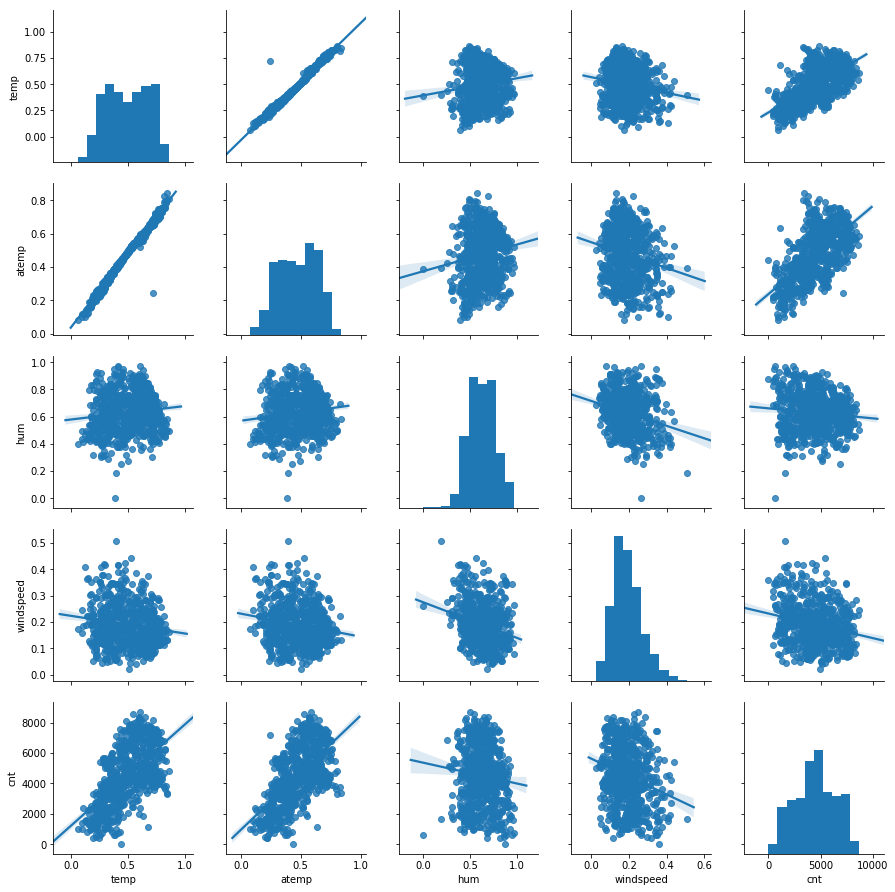

In [139]:
g = sns.PairGrid(df, vars=['temp', 'atemp', 'hum', 'windspeed', 'cnt'])
g = g.map_diag(plt.hist)
g = g.map_offdiag(sns.regplot)

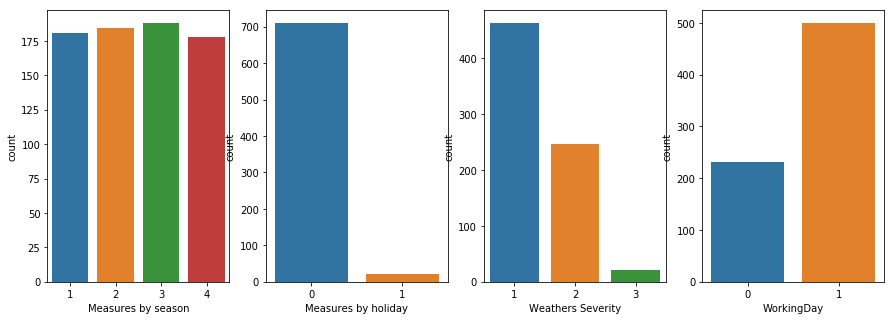

In [140]:
#Check distributions
plt.figure(figsize=(15,5))
plt.subplot(1,4,1)
sns.countplot(df.season)
plt.xlabel("Measures by season")
plt.subplot(1,4,2)
sns.countplot(df.holiday)
plt.xlabel("Measures by holiday")
plt.subplot(1,4,3)
sns.countplot(df.weathersit)
plt.xlabel("Weathers Severity")
plt.subplot(1,4,4)
sns.countplot(df.workingday)
plt.xlabel("WorkingDay")
plt.show()

#Good to see we aren't biasing toward types of seasons or weekdays.

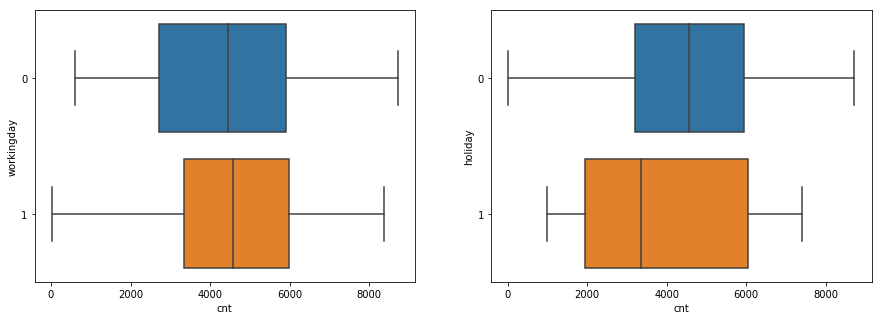

In [189]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.boxplot(x=df.cnt, y=df.workingday, orient='h')
plt.subplot(1,2,2)
sns.boxplot(x=df.cnt, y=df.holiday, orient='h')
plt.show()

#Neither of these look very meaningful, especially given that there are so few instances of holidays. 

In [141]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


# OLS Regression


Coefficients: 
 [ 6920.56038387 -2518.70858415   123.38489407    71.17401298]

Intercept: 
 1152.8951986846005

R-squared:
0.42833939916419395


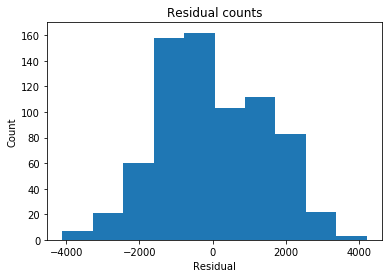

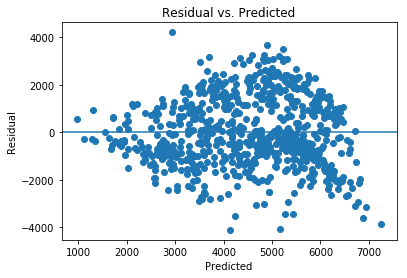

,atemp,windspeed,workingday,mnth
atemp,1.000000,-0.183643,0.052182,0.227459
windspeed,-0.183643,1.000000,-0.018796,-0.207502
workingday,0.052182,-0.018796,1.000000,-0.005901
mnth,0.227459,-0.207502,-0.005901,1.000000


In [142]:
regr = linear_model.LinearRegression()
X = df[['atemp', 'windspeed', 'workingday','mnth']]
Y = df['cnt']
regr.fit(X, Y)
# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))
predicted = regr.predict(X).ravel()
actual = df['cnt']
residual = actual - predicted
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

#check scedasticity
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()


#check multicollinearity
correlation_matrix = X.corr()
display(correlation_matrix)

In [143]:
#Duplicate the model in statsmodels to check feature p-values
linear_formula = 'cnt ~ atemp+windspeed+workingday+mnth'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=df).fit()
print(lm.params)
print(lm.pvalues)
print(lm.rsquared)
print(lm.conf_int())

Intercept     1152.895199
atemp         6920.560384
windspeed    -2518.708584
workingday     123.384894
mnth            71.174013
dtype: float64
Intercept     1.673403e-05
atemp         4.928571e-71
windspeed     5.389606e-04
workingday    2.921064e-01
mnth          1.672188e-05
dtype: float64
0.42833939916419395
                      0            1
Intercept    630.608809  1675.181588
atemp       6240.096853  7601.023914
windspeed  -3941.215634 -1096.201534
workingday  -106.377834   353.147622
mnth          38.931870   103.416156


In [108]:
#Working day is not adding value, and month is correlated with temp (somewhat).
#Remove those and add weather severity and humidity:


Coefficients: 
 [ 7220.34228646 -3857.39731559  -464.6201834  -1996.50971819]

Intercept: 
 3716.0355069135103

R-squared:
0.47313512865891616


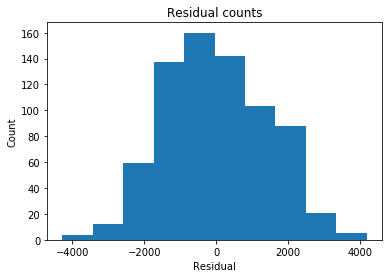

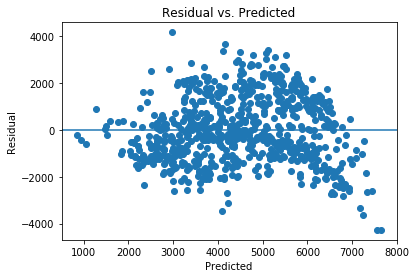

,atemp,windspeed,weathersit,hum
atemp,1.000000,-0.183643,-0.121583,0.139988
windspeed,-0.183643,1.000000,0.039511,-0.248489
weathersit,-0.121583,0.039511,1.000000,0.591045
hum,0.139988,-0.248489,0.591045,1.000000


In [144]:
regr = linear_model.LinearRegression()
X = df[['atemp', 'windspeed', 'weathersit','hum']]
Y = df['cnt']
regr.fit(X, Y)
# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))
predicted = regr.predict(X).ravel()
actual = df['cnt']
residual = actual - predicted
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

#check scedasticity
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()


#check multicollinearity
correlation_matrix = X.corr()
display(correlation_matrix)

In [145]:
#Duplicate the model in statsmodels to check feature p-values
linear_formula = 'cnt ~ atemp+windspeed+weathersit+hum'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=df).fit()
print("\nparameters\n",lm.params)
print("\np-values\n",lm.pvalues)
print("\nr-squared\n",lm.rsquared)
print("\nconfidence intervals\n",lm.conf_int())


parameters
 Intercept     3716.035507
atemp         7220.342286
windspeed    -3857.397316
weathersit    -464.620183
hum          -1996.509718
dtype: float64

p-values
 Intercept     8.224479e-26
atemp         1.439984e-79
windspeed     1.111412e-07
weathersit    2.318248e-04
hum           6.005362e-05
dtype: float64

r-squared
 0.47313512865891627

confidence intervals
                       0            1
Intercept   3047.997470  4384.073544
atemp       6560.198823  7880.485750
windspeed  -5269.931673 -2444.862958
weathersit  -711.144532  -218.095835
hum        -2967.589658 -1025.429779


In [146]:
X_digits = np.array(X)
Y_digits = np.array(Y)

cv = ShuffleSplit(test_size=0.1)
scores = cross_val_score(regr, X_digits, Y_digits, scoring="r2", cv=cv,)
print(scores)
print(scores.mean())

[0.37710941 0.39406445 0.34274045 0.34163308 0.53443101 0.54165862
 0.53306624 0.45003763 0.46762726 0.43597034]
0.44183384821233035


# KNN

In [203]:
X = df[['atemp', 'windspeed', 'weathersit','hum']].astype('float')
printthreshold = .55

print("no scaling or distance adjustments")
for i in range(1,15):
    knn = neighbors.KNeighborsRegressor(n_neighbors=i)
    
    Y = df['cnt']
    X = pd.DataFrame(X)
    knn.fit(X, Y)

    score_knn = cross_val_score(knn, X, Y, cv=cv)
    #print(score_knn)
    if score_knn.mean() > printthreshold:
        print(i, " : ",score_knn.mean())
print("no scaling, weighted by distance")
for i in range(1,15):
    knn = neighbors.KNeighborsRegressor(n_neighbors=i, weights='distance')
    
    Y = df['cnt']
    X = pd.DataFrame(X)
    knn.fit(X, Y)

    score_knn = cross_val_score(knn, X, Y, cv=cv)
    #print(score_knn)
    if score_knn.mean() > printthreshold:
        print(i, " : ",score_knn.mean())
print("scaled, no distance adjustments")
for i in range(1,15):
    knn = neighbors.KNeighborsRegressor(n_neighbors=i)
  
    X = MinMaxScaler().fit_transform(X)

    knn.fit(X, Y)

    score_knn = cross_val_score(knn, X, Y, cv=cv)
    #print(score_knn)
    if score_knn.mean() > printthreshold:
        print(i, " : ",score_knn.mean())
print("scaled and weighted for distance")
for i in range(1,15):
    knn = neighbors.KNeighborsRegressor(n_neighbors=i, weights='distance')
    
    X = MinMaxScaler().fit_transform(X)

    knn.fit(X, Y)

    score_knn = cross_val_score(knn, X, Y, cv=cv)
    #print(score_knn)
    if score_knn.mean() > printthreshold:
        print(i, " : ",score_knn.mean())

no scaling or distance adjustments
11  :  0.5620997490833899
12  :  0.5838111201862339
no scaling, weighted by distance
11  :  0.5851565405251453
12  :  0.569205238737093
scaled, no distance adjustments
12  :  0.5689564297348119
13  :  0.5558164599344393
14  :  0.5778273468673695
scaled and weighted for distance


In [207]:
X = df[['atemp', 'windspeed','hum']].astype('float')
printthreshold = .55

print("no scaling or distance adjustments")
for i in range(1,15):
    knn = neighbors.KNeighborsRegressor(n_neighbors=i)
    
    Y = df['cnt']
    X = pd.DataFrame(X)
    knn.fit(X, Y)

    score_knn = cross_val_score(knn, X, Y, cv=cv)
    #print(score_knn)
    if score_knn.mean() > printthreshold:
        print(i, " : ",score_knn.mean())
print("no scaling, weighted by distance")
for i in range(1,15):
    knn = neighbors.KNeighborsRegressor(n_neighbors=i, weights='distance')
    
    Y = df['cnt']
    X = pd.DataFrame(X)
    knn.fit(X, Y)

    score_knn = cross_val_score(knn, X, Y, cv=cv)
    #print(score_knn)
    if score_knn.mean() > printthreshold:
        print(i, " : ",score_knn.mean())
print("scaled, no distance adjustments")
for i in range(1,15):
    knn = neighbors.KNeighborsRegressor(n_neighbors=i)
  
    X = MinMaxScaler().fit_transform(X)

    knn.fit(X, Y)

    score_knn = cross_val_score(knn, X, Y, cv=cv)
    #print(score_knn)
    if score_knn.mean() > printthreshold:
        print(i, " : ",score_knn.mean())
print("scaled and weighted for distance")
for i in range(1,15):
    knn = neighbors.KNeighborsRegressor(n_neighbors=i, weights='distance')
    
    X = MinMaxScaler().fit_transform(X)

    knn.fit(X, Y)

    score_knn = cross_val_score(knn, X, Y, cv=cv)
    #print(score_knn)
    if score_knn.mean() > printthreshold:
        print(i, " : ",score_knn.mean())

no scaling or distance adjustments
6  :  0.5571290420663938
10  :  0.5516820792913322
14  :  0.5563532309642658
no scaling, weighted by distance
9  :  0.5737828697773294
11  :  0.5578735247283829
scaled, no distance adjustments
7  :  0.5606058651866104
9  :  0.5567035766377028
scaled and weighted for distance
13  :  0.5673606313798746
14  :  0.5590768974268022


In [192]:
X = df[['atemp', 'windspeed','hum']].astype('float')
printthreshold = .55

print("no scaling or distance adjustments")
for i in range(1,15):
    knn = neighbors.KNeighborsRegressor(n_neighbors=i)
    
    Y = df['cnt']
    X = pd.DataFrame(X)
    knn.fit(X, Y)

    score_knn = cross_val_score(knn, X, Y, cv=cv)
    #print(score_knn)
    if score_knn.mean() > printthreshold:
        print(i, " : ",score_knn.mean())
print("no scaling, weighted by distance")
for i in range(1,15):
    knn = neighbors.KNeighborsRegressor(n_neighbors=i, weights='distance')
    
    Y = df['cnt']
    X = pd.DataFrame(X)
    knn.fit(X, Y)

    score_knn = cross_val_score(knn, X, Y, cv=cv)
    #print(score_knn)
    if score_knn.mean() > printthreshold:
        print(i, " : ",score_knn.mean())
print("scaled, no distance adjustments")
for i in range(1,15):
    knn = neighbors.KNeighborsRegressor(n_neighbors=i)
  
    X = MinMaxScaler().fit_transform(X)

    knn.fit(X, Y)

    score_knn = cross_val_score(knn, X, Y, cv=cv)
    #print(score_knn)
    if score_knn.mean() > printthreshold:
        print(i, " : ",score_knn.mean())
print("scaled and weighted for distance")
for i in range(1,15):
    knn = neighbors.KNeighborsRegressor(n_neighbors=i, weights='distance')
    
    X = MinMaxScaler().fit_transform(X)

    knn.fit(X, Y)

    score_knn = cross_val_score(knn, X, Y, cv=cv)
    #print(score_knn)
    if score_knn.mean() > printthreshold:
        print(i, " : ",score_knn.mean())

no scaling or distance adjustments
8  :  0.5556888685682118
no scaling, weighted by distance
scaled, no distance adjustments
12  :  0.5700859048474625
scaled and weighted for distance


# Selected 3 for comparison:


R-squared:
0.47313512865891616


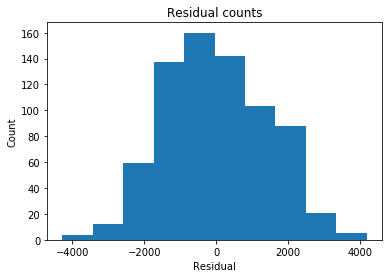

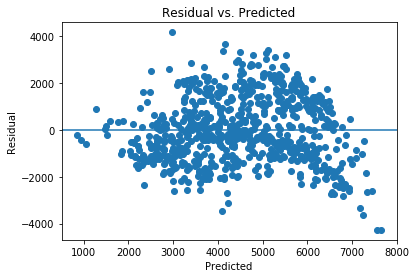

In [194]:
# OLS

ols = linear_model.LinearRegression()
X = df[['atemp', 'windspeed', 'weathersit','hum']]
Y = df['cnt']
ols.fit(X, Y)
# Inspect the results.
print('\nR-squared:')
print(ols.score(X, Y))
predicted = ols.predict(X).ravel()
actual = df['cnt']
residual = actual - predicted
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

#check scedasticity
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()


[0.48566969 0.55731903 0.53683232 0.60187213 0.51767188 0.63389264
 0.55382219 0.43106205 0.66476587 0.58527817]
0.5568185978371576


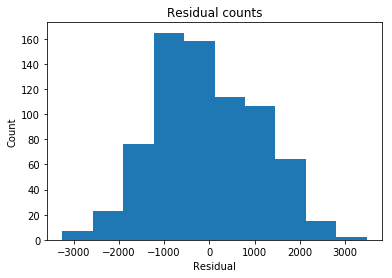

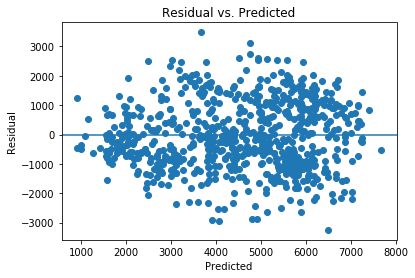

In [226]:
#TEST The KNN regression with no weighting, 8 neighbors

knn = neighbors.KNeighborsRegressor(n_neighbors=8)
X = df[['atemp', 'windspeed', 'weathersit','hum']].astype('float')
Y = df['cnt']
X = pd.DataFrame(X)
knn.fit(X, Y)
cv = ShuffleSplit(test_size=0.1)
score_knn = cross_val_score(knn, X, Y, cv=cv)
print(score_knn)
print(score_knn.mean())
predicted = knn.predict(X).ravel()
actual = df['cnt']
residual = actual - predicted
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

#check scedasticity
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()


[0.53082785 0.56734156 0.62015018 0.44784147 0.65313325 0.53559348
 0.34629964 0.67397897 0.4524357  0.56405631]
0.5391658389037997


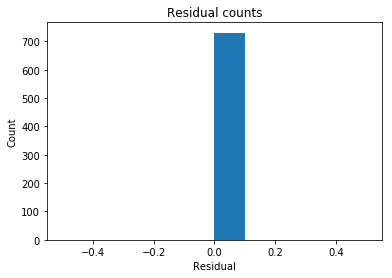

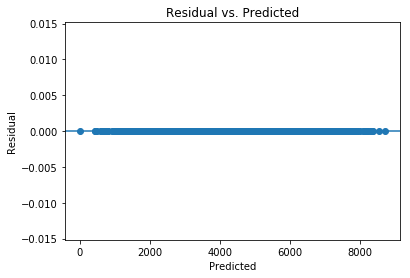

In [244]:
#Test the KNN regression with distance weighting, 9 neighbors

knn_dist = neighbors.KNeighborsRegressor(n_neighbors=9, weights='distance')
X = df[['atemp', 'windspeed','hum']]
Y = df['cnt']
knn_dist.fit(X, Y)
cv = ShuffleSplit(test_size=0.1)
score_knn = cross_val_score(knn_dist, X, Y, cv=cv)
print(score_knn)
print(score_knn.mean())
predicted = knn_dist.predict(X).ravel()

actual = df['cnt']
residual = actual - predicted
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

#check scedasticity
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()
